# water flow in CPlantBox

## Simulation of xylem water movement 


In the following we will show how to compute:

1. xylem water flux for a root segment for a pre-defined maximum transpiration 

2. xylem water flux and photosynthesis rate for a whole plant

We consider static root system and a static soil. 
To compute the water xylem flux we use the hybrid analytical approach of Meunier et al. (2017). Note that the model ist static (as most models are). To compute the photosynthesis rate and stomatal egulation, we use the FcVB-Leuning methode, as presented by Tuzet et al. (2003).

**Reference**

F Meunier, X Draye, J Vanderborght, M Javaux, V Couvreur. A hybrid analytical-numerical method for solving water flow equations in root hydraulic architectures. *Applied Mathematical modelling*, 2017.

A Tuzet, A Perrier, R Leuning. A coupled model of stomatal conductance, photosynthesis and transpiration. *Plant, Cell & Environment*, 2003.

In [1]:
import os
onCloud = True # the notebook is not being run on a local machine but on a cloud-based service (e.g. mybinder, googlecolab)

if onCloud:
    import xvfbwrapper
    vdisplay = xvfbwrapper.Xvfb()
    vdisplay.start()
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    doInteractiveImage = False
else:
    doInteractiveImage = True

    
sourcedir = os.getcwd()+"/../../.."
filedir = os.getcwd()
import sys; sys.path.append(sourcedir); sys.path.append(sourcedir+"/src")
import importlib
import plantbox as pb
import visualisation.vtk_plot as vp # for quick 3d vizualisations
import matplotlib.pyplot as plt # for 2d plots
import numpy as np

from functional.xylem_flux import XylemFluxPython  # Python hybrid solver
from functional.photosynthesis_cpp import PhotosynthesisPython

## 1. xylem flux in the root system

We present a minimal example with constant conductivities (based on *example6b_xylemflux.py*), where we give the soil water total potential per segment

In [75]:
""" root system """
simtime = 14  # [day] 
rs = pb.MappedRootSystem() # handles conductivity and mapping to the soil cells
path = "../../../modelparameter/structural/rootsystem/"
name = "Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010
rs.readParameters(path + name + ".xml")
random_parameters = rs.getOrganRandomParameter(pb.root)
for p in random_parameters[1:]:
    p.dx = 0.25 
verbose = False

rs.initialize(verbose) # note that an artificial root with type = 0 is added 
rs.simulate(simtime,verbose)
_ = vp.plot_roots(pb.SegmentAnalyser(rs.mappedSegments()), "subType",interactiveImage = doInteractiveImage) 

""" Parameters """
kz = 4.32e-2  # axial conductivity [cm^3/day]
kr = 1.728e-4  # radial conductivity [1/day]
p_top = -300 #-14990  # top soil pressure [cm]
p0 = -500  # dirichlet bc at root collar [cm]
trans = -1.2  # neuman bc at root collar [cm3/day]

""" prepare soil matric potentials per segment"""
segs = rs.segments # MappedRootSystem has access to segments and nodes 
nodes = rs.nodes
p_s = np.zeros((len(segs),)) # soil total potentials around each root segment
for i, s in enumerate(segs):
    p_s[i] = p_top - 0.5 * (nodes[s.x].z + nodes[s.y].z)  # constant total potential (hydraulic equilibrium)

""" root problem """
r = XylemFluxPython(rs)
r.setKr([0., kr, kr , kr, kr, kr]) # no radial flux into the artificial root segment
r.setKx([1., kz, kz, kz, kz, kz])

""" Numerical solution """
#
# In the following 'cells = False' means total soil potentials 'p_s' is given for each segment
#

# rx = r.solve_neumann(simtime, trans, p_s, cells = False) # use Neumann bc 
# rx = r.solve_dirichlet(simtime, p0, 0, p_s, cells = False) # use Dirichlet bc
rx = r.solve(simtime, trans, 0, p_s, cells= False, wilting_point = -15000) # use Neumann, switch to Dirichlet if below wilting_point

fluxes1 = r.segFluxes(simtime, rx, p_s, cells = False)  # [cm3/day]
print("Transpiration", r.collar_flux(simtime, rx, [p_s], k_soil = [], cells = False), "cm3/day")


Transpiration -1.2000000000000077 cm3/day


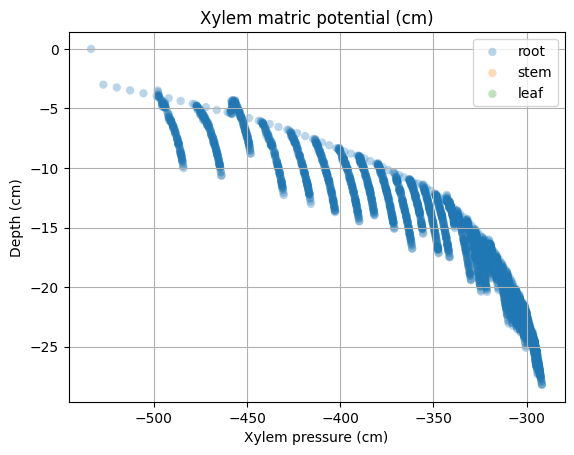

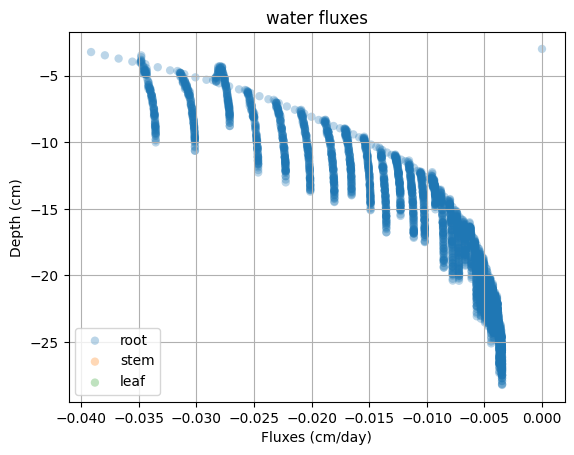

In [76]:

surfs = np.multiply(np.array(r.rs.segLength()), 2*np.array(r.rs.radii)*np.pi)  # root segment side surface [cm2]
fluxes = np.divide(fluxes1, surfs)  # we convert to [cm3/(cm2 day)]

""" plot results """
ana = pb.SegmentAnalyser(r.rs.mappedSegments())
ana.addData("rx", rx) # add simulation result
_ = vp.plot_roots(ana, "rx", "Xylem matric potential (cm)",interactiveImage = doInteractiveImage)  
ana.addData("fluxes", fluxes) # add simulation result 
_ = vp.plot_roots(ana, "fluxes", "Segment flux (cm/day)",interactiveImage = doInteractiveImage) 


fig, ax = plt.subplots()
name = ["root", "stem", "leaf"]
color = ['tab:blue', 'tab:orange', 'tab:green']
for ndType in [2, 3, 4]:
    #nodes = self.get_nodes()
    y = r.get_nodes_organ_type(ndType)#coordinates
    x = np.array(rx)[r.get_nodes_index(ndType)]
    ax.scatter(x, y[:,2], c=color[ndType-2],  label=name[ndType-2],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
plt.xlabel("Xylem pressure (cm)")
plt.ylabel("Depth (cm)")
plt.title("Xylem matric potential (cm)")
plt.show()


fig, ax = plt.subplots()
name = ["root", "stem", "leaf"]
color = ['tab:blue', 'tab:orange', 'tab:green']
for ndType in [2, 3, 4]:
    segIdx = r.get_segments_index(ndType)
    nodesy = segIdx + np.ones(segIdx.shape, dtype = np.int64)
    nodes = r.get_nodes()
    y = np.array(nodes)[nodesy]#coordinates
    x = fluxes[segIdx]
    ax.scatter(x, y[:,2], c=color[ndType-2],  label=name[ndType-2],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
plt.xlabel("Fluxes (cm/day)")
plt.ylabel("Depth (cm)")
plt.title("water fluxes")
plt.show()


## Take away messages

* Basic idea how to use the class *XylemFluxPython*
* How to set the root axial and radial conductivities in the class *MappedRootSystem*
* Look at the outputs of the xylem model

## 2. Xylem flux in the whole plant and photosynthesis 

We present a minimal example with constant conductivities. 

In [38]:
import functional_parameters
# from importlib import reload
# functional_parameters = reload(functional_parameters)

simtime = 30  # [day] 
pl = pb.MappedPlant() #for plant objects
path = "../../../modelparameter/structural/plant/" 
name = "fspm2023" 
pl.readParameters(path + name + ".xml")

soilSpace = pb.SDF_PlantContainer(500,500, 500, True) #to avoid root growing aboveground
pl.setGeometry(soilSpace) # creates soil space to stop roots from growing out of the soil

verbose = False
pl.initialize(verbose)
pl.simulate(simtime,verbose)


" Coupling to soil "
depth = 60 #cm
p_top = -1000  # top soil total potential [cm]
p_bot = p_top +depth # bot total potential [cm]
p_s = np.linspace(p_top, p_top - depth, depth) # We give the total potential per soil layer
soil_index = lambda x,y,z : max(int(np.floor(-z)),-1) # abovegroud nodes get index -1
pl.setSoilGrid(soil_index)


We set the parameters:

In [77]:

#we give as input the initial guess of water potential and internal CO2 concentration
#for the fixed-point iteration
cs = 350e-6
r = PhotosynthesisPython(pl, min(p_s), cs*0.7) #Equivalent to XylemFluxPython() for whole plant
r.PhotoType=pb.C3 # pb.C4

""" Set up organ conductivities and atmospheric conditions"""
r = functional_parameters.photosynthesisParam(r)


Launche simulation:

In [78]:
#
# In the following 'cells = True' means total soil potentials 'p_s' is given for soil voxel
#
r.solve_photosynthesis(sim_time_ = simtime, 
                                sxx_=p_s, 
                                cells_ = True,
                                ea_ =  r.weatherX["ea"], 
                                es_= r.weatherX["es"], 
                                verbose_ = False, doLog_ = False,
                                TairC_=  r.weatherX["TairC"], 
                                            soil_k_ = [],  
                                outputDir_= "./results/rhizoplantExud")

plantWatPot = r.psiXyl
fluxes = r.radial_fluxes(simtime, plantWatPot, p_s,[], True)  # cm3/day
surfs = np.multiply(np.array(r.rs.segLength()), 2*np.array(r.rs.radii)*np.pi)  # root segment side surface [cm2]
fluxes = np.divide(fluxes, surfs)  # we convert to [cm3/(cm2 day)]

# Make sure to let the solve_photosynthesis() function finish before starting the block of code below.




Present outputs:

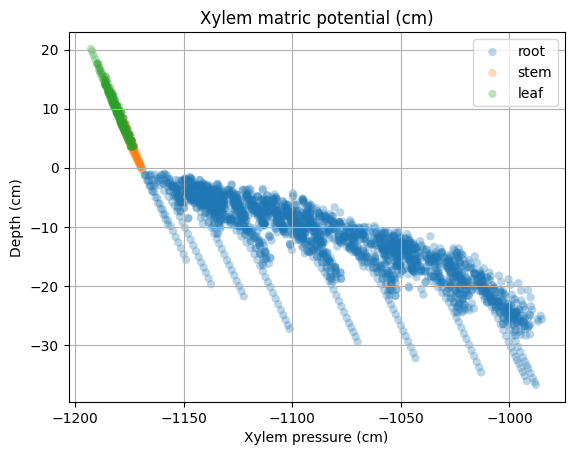

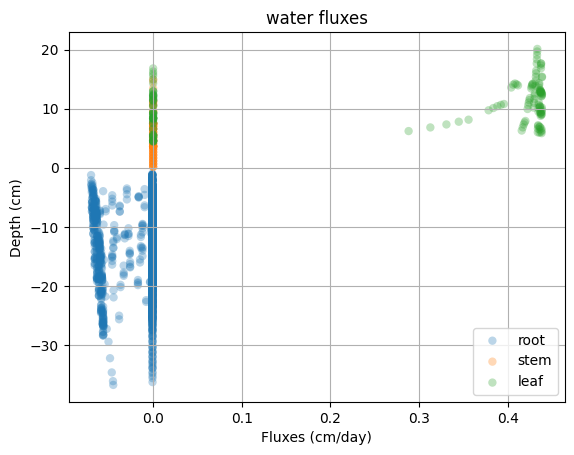

Net assimilation 0.8684650928096593 mmol CO2 m-2 s-1
Transpiration 42.02863301331095 cm3/day


In [79]:



fig, ax = plt.subplots()
name = ["root", "stem", "leaf"]
color = ['tab:blue', 'tab:orange', 'tab:green']
for ndType in [2, 3, 4]:
    #nodes = self.get_nodes()
    y = r.get_nodes_organ_type(ndType)#coordinates
    x = np.array(plantWatPot)[r.get_nodes_index(ndType)]
    ax.scatter(x, y[:,2], c=color[ndType-2],  label=name[ndType-2],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
plt.xlabel("Xylem pressure (cm)")
plt.ylabel("Depth (cm)")
plt.title("Xylem matric potential (cm)")
plt.show()


fig, ax = plt.subplots()
name = ["root", "stem", "leaf"]
color = ['tab:blue', 'tab:orange', 'tab:green']
for ndType in [2, 3, 4]:
    segIdx = r.get_segments_index(ndType)
    nodesy = segIdx + np.ones(segIdx.shape, dtype = np.int64)
    nodes = r.get_nodes()
    y = np.array(nodes)[nodesy]#coordinates
    x = fluxes[segIdx]
    ax.scatter(x, y[:,2], c=color[ndType-2],  label=name[ndType-2],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
plt.xlabel("Fluxes (cm/day)")
plt.ylabel("Depth (cm)")
plt.title("water fluxes")
plt.show()


print("Net assimilation", np.sum(r.An)*1e3, "mmol CO2 m-2 s-1")

print("Transpiration", sum(fluxes[r.get_segments_index(4)]), "cm3/day")


In [80]:

fluxes_ = fluxes
fluxes_ =  np.insert(fluxes_, 0, 0)
fluxes_[np.where(fluxes_ == 0)] = np.nan # set nan for 0 value to make it easier to see

_ = vp.plot_plant(r.rs,  'fluxes', vals=[fluxes_],interactiveImage = doInteractiveImage)  

## Take away messages

* Basic idea how to use the class *Photosynthesis*
* Some outputs of the photosynthesis model
